In [1]:
import pandas as pd 
import numpy as np
import os 

In [2]:
def replace_as_numerical(x): 
  if isinstance(x, (float,int)): 
    return x
  if x.endswith('B'): 
    n = x.strip('B')
    n = float(n)*1_000_000_000
  elif x.endswith('M'):
    n = x.strip('M')
    n = float(n)*1_000_000 
  elif x.endswith('k'): 
    n = x.strip('k')
    n = float(n)*1_000 
  elif x.endswith('µ'):
    n = x.strip('µ')
    n = float(n) * 0.00001
  else: 
    n = float(x)
  return n 

In [3]:
dataframes = [pd.read_csv(f'data/{fn}', index_col='country')
              .applymap(replace_as_numerical)
              .reset_index()
              .assign(feature=fn.strip('.csv'))
              .pipe(pd.melt, id_vars=['feature', 'country'], var_name='year')
              .dropna() for fn in os.listdir('data')]

In [4]:
dataset = pd.concat(dataframes, axis=0)\
  .pipe(pd.pivot_table, index=['country', 'year'], columns='feature', values='value') \
  .reset_index() \
  .assign(year=lambda df: pd.to_numeric(df['year']))

dataset

feature,country,year,eg_fec_rnew_z,en_co2_tran_z,gdp_pcap,o2_emissions_tonnes_per_person,oal_consumption_per_cap,oil_consumption_per_cap,urban_population_percent_of_total
0,Afghanistan,1800,NaN,NaN,583.0,NaN,NaN,NaN,NaN
1,Afghanistan,1801,NaN,NaN,583.0,NaN,NaN,NaN,NaN
2,Afghanistan,1802,NaN,NaN,583.0,NaN,NaN,NaN,NaN
3,Afghanistan,1803,NaN,NaN,583.0,NaN,NaN,NaN,NaN
4,Afghanistan,1804,NaN,NaN,583.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
60011,Zimbabwe,2096,NaN,NaN,6750.0,NaN,NaN,NaN,NaN
60012,Zimbabwe,2097,NaN,NaN,6890.0,NaN,NaN,NaN,NaN
60013,Zimbabwe,2098,NaN,NaN,7080.0,NaN,NaN,NaN,NaN
60014,Zimbabwe,2099,NaN,NaN,7200.0,NaN,NaN,NaN,NaN


In [5]:
#rename columns
dataset.rename(columns={
    'eg_fec_rnew_z': 'renewable_energy_percent',
    'en_co2_tran_z': 'co2_from_transport',
    'o2_emissions_tonnes_per_person': 'co2_emit_per_person',
    'oal_consumption_per_cap': 'coal_consumption_per_cap'
}, inplace=True)


In [6]:
dataset.isnull().sum()

feature
country                                  0
year                                     0
renewable_energy_percent             53945
co2_from_transport                   54114
gdp_pcap                              1321
co2_emit_per_person                  41779
coal_consumption_per_cap             55946
oil_consumption_per_cap              55952
urban_population_percent_of_total    46686
dtype: int64

In [7]:
filtered_df = dataset.dropna()
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1950 entries, 792 to 58964
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            1950 non-null   object 
 1   year                               1950 non-null   int64  
 2   renewable_energy_percent           1950 non-null   float64
 3   co2_from_transport                 1950 non-null   float64
 4   gdp_pcap                           1950 non-null   float64
 5   co2_emit_per_person                1950 non-null   float64
 6   coal_consumption_per_cap           1950 non-null   float64
 7   oil_consumption_per_cap            1950 non-null   float64
 8   urban_population_percent_of_total  1950 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 152.3+ KB


In [8]:
import statsmodels.formula.api as smf 
import statsmodels.api as sm

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

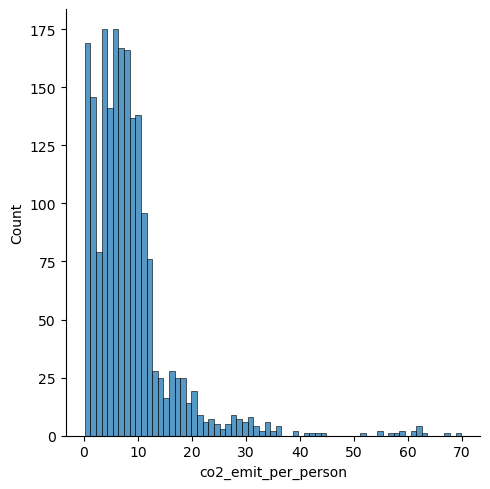

In [10]:
# Check to see if the response variable is normally distributed
sns.displot(x='co2_emit_per_person',data=filtered_df)

In [11]:
from scipy.special import boxcox

<Axes: ylabel='Density'>

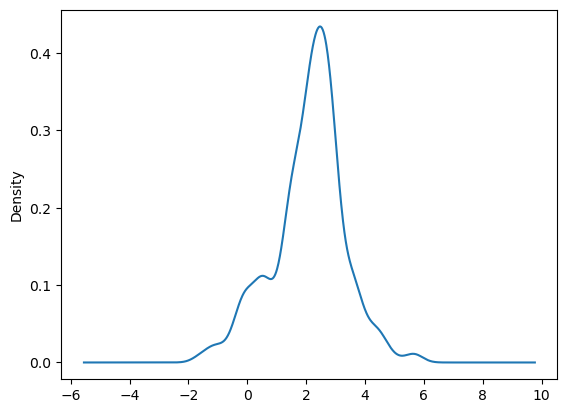

In [12]:
filtered_df.assign(transformed_co2 = lambda df: boxcox(df['co2_emit_per_person'],0.15))['transformed_co2'] \
.plot(kind='kde')

In [13]:
filtered_df = filtered_df.assign(transformed_co2 = lambda df: boxcox(df['co2_emit_per_person'],0.15))

In [14]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1950 entries, 792 to 58964
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            1950 non-null   object 
 1   year                               1950 non-null   int64  
 2   renewable_energy_percent           1950 non-null   float64
 3   co2_from_transport                 1950 non-null   float64
 4   gdp_pcap                           1950 non-null   float64
 5   co2_emit_per_person                1950 non-null   float64
 6   coal_consumption_per_cap           1950 non-null   float64
 7   oil_consumption_per_cap            1950 non-null   float64
 8   urban_population_percent_of_total  1950 non-null   float64
 9   transformed_co2                    1950 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 232.1+ KB


<Axes: xlabel='feature', ylabel='feature'>

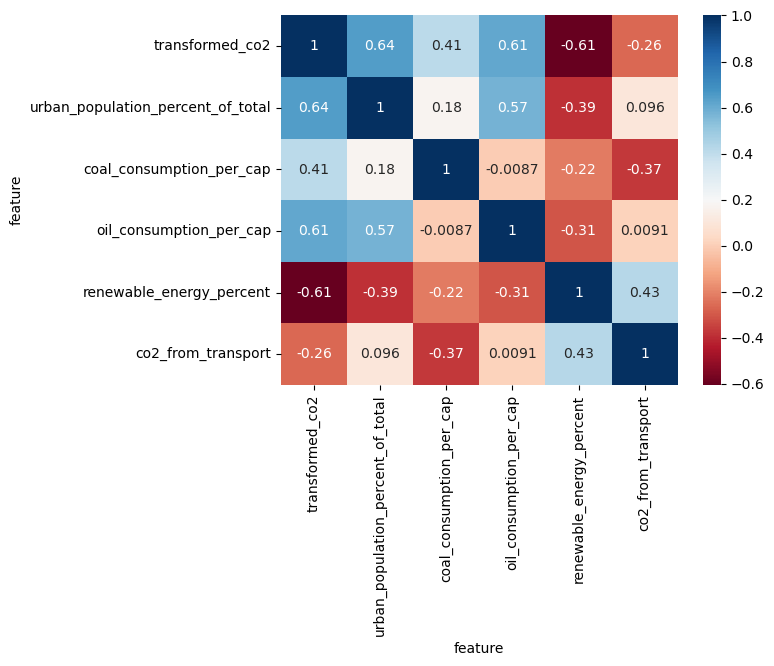

In [16]:
filtered_df.loc[:,['transformed_co2','urban_population_percent_of_total','coal_consumption_per_cap','oil_consumption_per_cap','renewable_energy_percent','co2_from_transport']].corr() \
        .pipe(sns.heatmap, cmap='RdBu', annot=True)

In [17]:
# first linear model
co2_model1 = smf.ols('transformed_co2~urban_population_percent_of_total',data=filtered_df).fit()
co2_model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        transformed_co2   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     1377.
Date:                Sat, 12 Aug 2023   Prob (F-statistic):          1.79e-228
Time:                        21:41:50   Log-Likelihood:                -2629.9
No. Observations:                1950   AIC:                             5264.
Df Residuals:                    1948   BIC:                             5275.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.7756      0.080     -9.686      0.000      -0.933      -0.619
urban_population_percent_of_total     0.0423      0.001     37.111      0.000       0.040       0.045
==============================================================================
Omnibus:                        4.933   Durbin-Watson:                   0.093
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                5.714
Skew:                           0.021   Prob(JB):                       0.0574
Kurtosis:                       3.262   Cond. No.                         266.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

transformed_co2 = -0.7756 + 0.0423 * urban_population_percent_of_total

In the initial OLS model, I focused on exploring the relationship between CO2 emissions per person as the dependent variable and urban population percentage as the sole independent variable. I chose urban population percentage as an independent variable because it exhibited a moderate correlation of 0.64 with CO2 emissions in the correlation heatmap.
Upon analyzing the OLS regression results, we observed an r-squared value of 0.414, indicating approximately 41.4% of the variation in the dependent variable can be explained by the independent variables included in the model, so that we should include more variables in the next model. Notably, the p-value of the urban population percentage is 0, which is smaller than the significance level of 0.05, suggesting that urban population percentage significantly influences CO2 emissions. Furthermore, the coefficient of the urban population percentage is 0.0423, and it holds a positive sign, indicating that the thriving of urbanization leads to increased CO2 emissions to meet people's demands in the city. This finding highlights the role of urbanization in contributing to CO2 emissions.

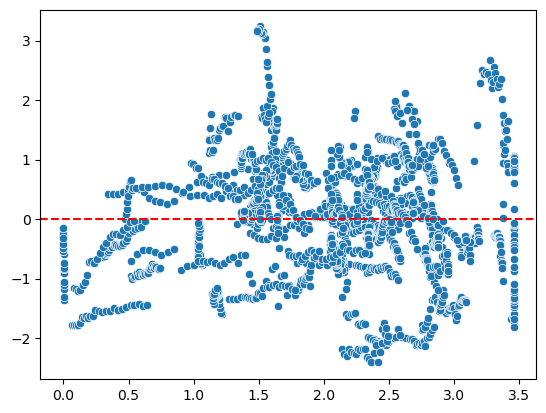

In [18]:
#checking heteroscedasticity for model 1
sns.scatterplot(y=co2_model1.resid,x=co2_model1.fittedvalues)
plt.axhline(y=0, linestyle='dashed', color='r')

In this graph, we can clearly see that most of the data points are symmetrically distributed around the x-axis, suggesting the absence of heteroscedasticity.

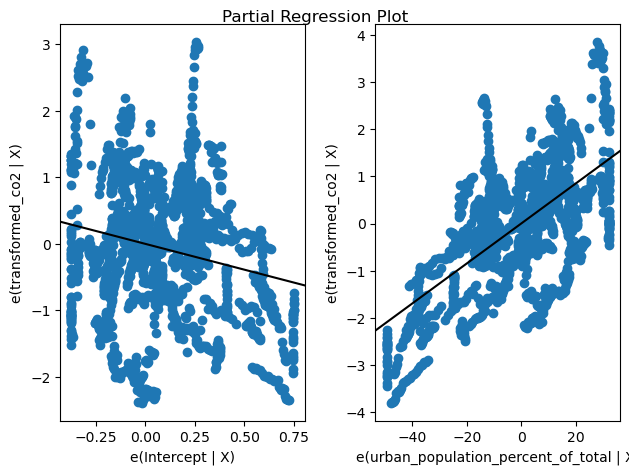

In [19]:
fig=sm.graphics.plot_partregress_grid(co2_model1)

From the right partial regression plot, we can observe a positive correlation between urban population percent of total and CO2 emissions per person.

In [20]:
#second linear model 
co2_model2 = smf.ols('transformed_co2~urban_population_percent_of_total+coal_consumption_per_cap+oil_consumption_per_cap',data=filtered_df).fit()
co2_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        transformed_co2   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     1068.
Date:                Sat, 12 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:42:09   Log-Likelihood:                -2202.5
No. Observations:                1950   AIC:                             4413.
Df Residuals:                    1946   BIC:                             4435.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.2315      0.069     -3.364      0.001      -0.366      -0.097
urban_population_percent_of_total     0.0223      0.001     19.475      0.000       0.020       0.025
coal_consumption_per_cap              0.6999      0.028     24.844      0.000       0.645       0.755
oil_consumption_per_cap               0.3231      0.013     24.471      0.000       0.297       0.349
==============================================================================
Omnibus:                      189.142   Durbin-Watson:                   0.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1166.998
Skew:                           0.207   Prob(JB):                    3.89e-254
Kurtosis:                       6.767   Cond. No.                         286.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

transformed_co2 = -0.2315 + 0.0223 * urban_population_percent_of_total + 0.6999 * coal_consumption_per_cap + 0.3231 * oil_consumption_per_cap

In the second linear model, I incorporated two additional independent variables: coal consumption per person and oil consumption per person. These variables directly contribute to increased CO2 emissions through the burning of fossil fuels, which aligns with common sense. Plus, they exhibit mild and moderate correlations of 0.41 and 0.61, respectively, with transformed CO2 emission variable. Upon analyzing the OLS regression model, we observe coefficients of 0.0223, 0.6999, and 0.3231 for urban population percentage, coal consumption per person, and oil consumption per person, respectively. These coefficients indicate that an increase in population, coal consumption, or oil consumption results in a corresponding increase in CO2 emissions. The r-sqaured value of this model has increased to 0.622, so approximately 62.2% of the variation in the dependent variable can be explained by the independent variables included in the model, showing the newly joined variables have improved the model. Moreover, nearly all variables in the model exhibit a p-value smaller than 0.05, signifying the statistical significance of urban population percentage, coal consumption, and oil consumption as influential factors in explaining the variation in CO2 emissions within this model. 

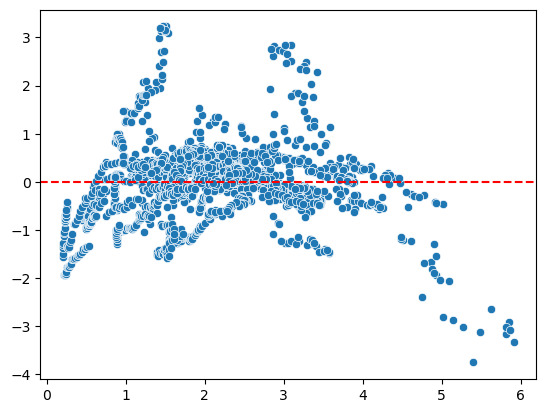

In [21]:
#checking heteroscedasticity for model 2
sns.scatterplot(y=co2_model2.resid,x=co2_model2.fittedvalues)
plt.axhline(y=0, linestyle='dashed', color='r')

In this graph, we can observe a distinctive cone-shaped pattern of points above the x=0 line, signifying that the model's residuals exhibit varying variance and the presence of heteroscedasticity.

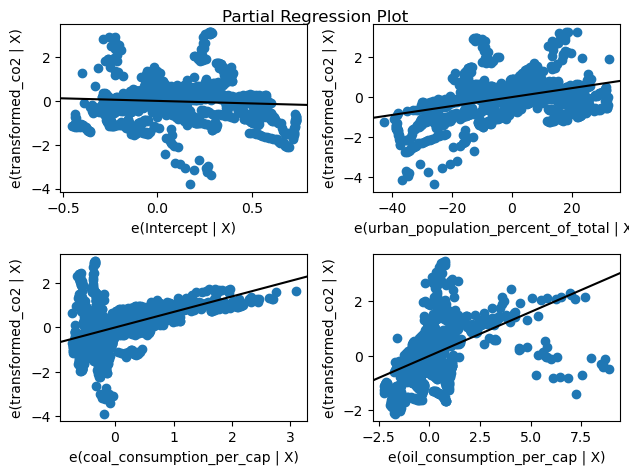

In [22]:
#checking partial regression plots for model 2
fig=sm.graphics.plot_partregress_grid(co2_model2)

From this graph, we can see an upward slope of the lines in the graphs of urban population percent of total, coal consumption per cap and oil consumption per cap, showing the positive correlation between these variables and co2 emission per person. 

In [23]:
#checking vif for model 2
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [24]:
names = co2_model2.model.exog_names

In [25]:
dm = co2_model2.model.exog

In [26]:
vifs = [vif(dm, i) for i in range(4)]

In [27]:
for v,n in zip(vifs, names): 
    print(f"{n:<20} {v:.4f}")

Intercept            16.4428
urban_population_percent_of_total 1.5683
coal_consumption_per_cap 1.0511
oil_consumption_per_cap 1.5202


Intercept: The VIF for the intercept is 16.4428. This value represents the degree of multicollinearity between the constant term (intercept) and the other independent variables in the model. Since the intercept is not a real independent variable, the high VIF value is expected and not a concern.

Urban Population Percentage: The VIF for urban population percentage is 1.5683. This indicates a relatively low level of multicollinearity between urban population percentage and the other independent variables, which is a good sign.

Coal Consumption per Capita: The VIF for coal consumption per capita is 1.0511. This value is close to 1, suggesting little to no multicollinearity between coal consumption and the other independent variables.

Oil Consumption per Capita: The VIF for oil consumption per capita is 1.5202. Similar to coal consumption, this value is also close to 1, indicating minimal multicollinearity with the other independent variables.

Overall, the VIF values are relatively close to 1 for all independent variables, indicating that there is no significant multicollinearity among the predictors in the model. This is favorable as high VIF values (usually above 5 or 10) can indicate strong multicollinearity, which may affect the accuracy and interpretation of the regression model. In this case, the VIF values suggest that the independent variables can be considered independently in the model without causing issues due to multicollinearity.

In [28]:
#third linear model
co2_model3 = smf.ols('transformed_co2~renewable_energy_percent+coal_consumption_per_cap+oil_consumption_per_cap+urban_population_percent_of_total',data=filtered_df).fit()
co2_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        transformed_co2   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     1187.
Date:                Sat, 12 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:42:33   Log-Likelihood:                -1946.2
No. Observations:                1950   AIC:                             3902.
Df Residuals:                    1945   BIC:                             3930.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.6405      0.070      9.109      0.000       0.503       0.778
renewable_energy_percent             -0.0228      0.001    -24.179      0.000      -0.025      -0.021
coal_consumption_per_cap              0.5858      0.025     23.287      0.000       0.536       0.635
oil_consumption_per_cap               0.2826      0.012     24.149      0.000       0.260       0.306
urban_population_percent_of_total     0.0166      0.001     16.089      0.000       0.015       0.019
==============================================================================
Omnibus:                      219.746   Durbin-Watson:                   0.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1566.461
Skew:                           0.259   Prob(JB):                         0.00
Kurtosis:                       7.360   Cond. No.                         339.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

co2_emit_per_person = 2.5512 + 0.0335 * urban_population_percent_of_total + 2.4832 * coal_consumption_per_cap + 2.5455 * oil_consumption_per_cap - 0.0780 * renewable_energy_percent

In the third linear model, I introduced an additional variable, namely renewable energy percentage (of all energy consumption). I chose this variable since it has a moderate correlation of -0.61 with co2 emission per person and I regard this variable could have a negative correlation with the transformed co2 emission per person. When we analyze the OLS regression result, we find that all variables, except for renewable energy percentage, have positive coefficients. This suggests that as coal consumption, oil consumption, and urban population increase, so does the CO2 emission. Conversely, since renewable energy percentage exhibits a negative coefficient, an increase in the adoption of renewable energy leads to a decrease in CO2 emissions, which aligns with common sense expectations. All variables have p-value less than 0.05, which means all of them are significant variables to this model. The r-squared value has also improved from 0.622 to 0.709, indicating approximately 70.9% of the variation in the dependent variable can be explained by the independent variables included in the model. 

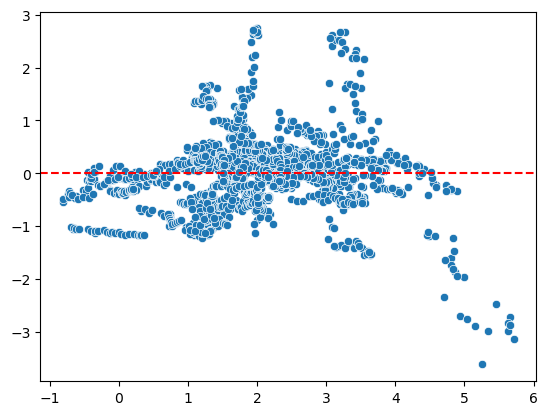

In [29]:
#checking heteroscedasticity
sns.scatterplot(y=co2_model3.resid,x=co2_model3.fittedvalues)
plt.axhline(y=0, linestyle='dashed', color='r')

In this graph, we can observe a distinctive cone-shaped pattern of points above the middle of x=0 line, signifying that the model's residuals exhibit varying variance and the presence of heteroscedasticity.

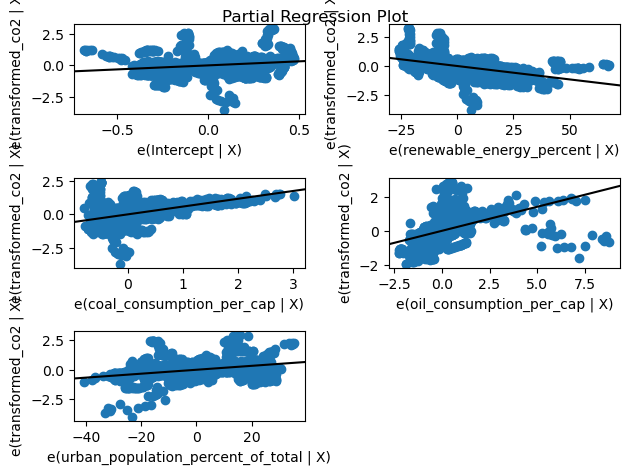

In [30]:
#checking partial regression plots
fig=sm.graphics.plot_partregress_grid(co2_model3)

From this partial regression plot, we can observe that the majority of the data points closely align with the partial regression line. The positive slope of the line in the graphs of coal consumption per cap, oil consumption per cap, and urban population percent of total suggests a positive correlation between these variables and CO2 emission per person. Conversely, the negative slope of the line in the renewable energy percent graph indicates a negative correlation between renewable energy percent and CO2 emission per person. The steepness of the line in the oil consumption per cap graph signifies that oil consumption per cap has a substantial impact on CO2 emission per person. On the other hand, the less steep lines in the other variables' graphs suggest that they might not influence CO2 emission per person as significantly as oil consumption per cap does.

In [31]:
#checking multicollinearity
names = co2_model3.model.exog_names

In [32]:
dm = co2_model3.model.exog

In [33]:
vifs = [vif(dm, i) for i in range(5)]

In [34]:
for v,n in zip(vifs, names): 
    print(f"{n:<20} {v:.4f}")

Intercept            22.3123
renewable_energy_percent 1.2365
coal_consumption_per_cap 1.0894
oil_consumption_per_cap 1.5520
urban_population_percent_of_total 1.6548


The VIF for the intercept is 22.3123. The intercept represents the constant term in the model and is not a real independent variable. The high VIF value is expected for the intercept and doesn't affect the interpretation of the other variables. In conclusion, the VIF values for all the independent variables are relatively close to 1 or at a moderate level, suggesting that there is no severe multicollinearity among the predictors in the model. This is beneficial as high VIF values (typically above 5 or 10) could lead to inaccurate or unstable regression results. With these VIF values, the independent variables can be safely included in the model without substantial multicollinearity concerns.

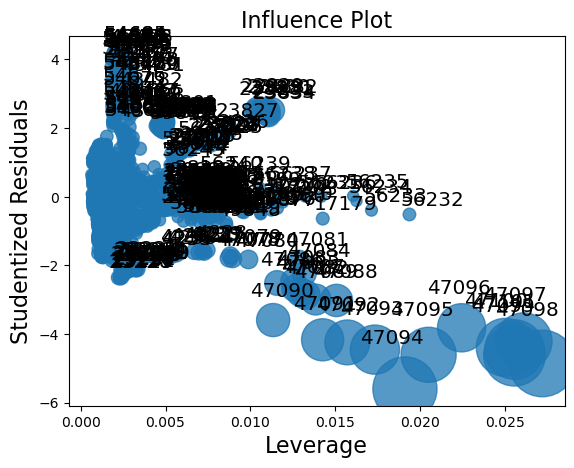

In [37]:
fig=sm.graphics.influence_plot(co2_model3)

In [ ]:
#anova test among three models
sm.stats.anova_lm(co2_model1,co2_model2,co2_model3)

In [44]:
co2_model1.mse_resid

0.8697804010771072

In [39]:
co2_model2.mse_resid

0.5616519010194588

In [38]:
co2_model3.mse_resid

0.432073199656092

#hypothesis test for co2_model1 and co2_model2
H0: co2_model1: transformed_co2 = b1 * urban_population_percent_of_total (b2=b3=0)
H1: co2_model2: transformed_co2 = b1 * urban_population_percent_of_total + b2 * coal_consumption_per_cap + 
b3 * oil_consumption_per_cap
From the anova test result (row 1), the Pr(>F) value for is 1.022449e-228 < 0.05. Therefore, assuming that co2_model1, we can reject the null hypothesis that b2=b3=0, i.e. at least coal_consumption_per_cap or oil_consumption_per_cap does explain variation in transformed_co2.

#hypothesis test for co2_model2 and co2_model3
H0: co2_model2: transformed_co2 = b1 * urban_population_percent_of_total + b2 * coal_consumption_per_cap + 
b3 * oil_consumption_per_cap (b4 = 0)
H1: co2_model3: transformed_co2 = b1 * urban_population_percent_of_total + b2 * coal_consumption_per_cap + 
b3 * oil_consumption_per_cap - b4 * renewable_energy_percent
From the anova test result (row 2), the Pr(>F) value is 3.804585e-113 < 0.05. Therefore, assuming that co2_model2, we can reject the null hypothesis that b4=0, i.e. renewable_energy_percent is a significant independent variable to transformed_co2.

From the above anova and hypothesis testing, we come to the conclusion that those four variables are significant to the model, thus we choose co2_model3 that includes all these four variables. 

In [ ]:
sns.scatterplot(data=filtered_df, x='coal_consumption_per_cap', y='transformed_co2')

In [ ]:
sns.scatterplot(data=filtered_df, x='oil_consumption_per_cap', y='transformed_co2')

In [ ]:
sns.scatterplot(data=filtered_df, x='oil_consumption_per_cap', y='co2_emit_per_person')

In [ ]:
#polynomial regression
co2_model4 = smf.ols('transformed_co2~renewable_energy_percent+coal_consumption_per_cap+oil_consumption_per_cap+urban_population_percent_of_total + I(oil_consumption_per_cap**2)',data=filtered_df).fit()
co2_model4.summary()

In [ ]:
sm.stats.anova_lm(co2_model3,co2_model4)

In [ ]:
filtered_df.info()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

# Select independent variables and response variable
X = filtered_df[['renewable_energy_percent',
             'coal_consumption_per_cap', 'oil_consumption_per_cap', 'urban_population_percent_of_total']]
y = filtered_df['transformed_co2']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the independent variables using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up the alphas for RidgeCV
alphas = np.logspace(-2, 5, 20)

# Create the RidgeCV model
ridge = RidgeCV(alphas=alphas, cv=5)

# Fit the RidgeCV model on the training data
ridge.fit(X_train_scaled, y_train)

# Get the coefficient estimates
coef_estimates = ridge.coef_

# Get the R-squared score on the test data
r_squared = ridge.score(X_test_scaled, y_test)

# Get the best alpha value selected by RidgeCV
best_alpha = ridge.alpha_

print("Coefficient Estimates:", coef_estimates)
print("R-squared on Test Data:", r_squared)
print("Best Alpha:", best_alpha)


Certainly, let's interpret the results of your Ridge regression model:

1. **Coefficient Estimates**:
   - `renewable_energy_percent`: -0.3776
   - `coal_consumption_per_cap`: 0.3514
   - `oil_consumption_per_cap`: 0.4882
   - `urban_population_percent_of_total`: 0.2856

   These coefficients represent the change in the predicted outcome (`transformed_co2`) for a one-unit change in the corresponding independent variable while keeping other variables constant. For example:
   - An increase in `renewable_energy_percent` is associated with a decrease in the predicted `transformed_co2`.
   - An increase in `coal_consumption_per_cap`, `oil_consumption_per_cap`, and `urban_population_percent_of_total` is associated with an increase in the predicted `transformed_co2`.

2. **R-squared on Test Data**: 0.7062
   - The R-squared value represents the proportion of the variance in the dependent variable (`transformed_co2`) that is explained by the independent variables in the model. In your case, around 70.62% of the variance in `transformed_co2` is explained by the independent variables you used in the model.

3. **Best Alpha**: 20.6914
   - The best alpha value selected by RidgeCV is 20.6914. This value represents the strength of the regularization applied to your model. A higher alpha value indicates stronger regularization. It seems your model has opted for a relatively high alpha value, suggesting that it prefers a higher level of regularization to prevent overfitting.

Overall, your Ridge regression model with the selected independent variables has achieved a moderate level of prediction accuracy, as indicated by the R-squared value. The choice of higher alpha indicates that the model is emphasizing regularization to prevent overfitting, which can be beneficial when dealing with potential multicollinearity or high-dimensionality in the data.

In [ ]:
bin_edges = [0.0672, 10.000, 69.9]

labels = pd.cut(filtered_df.co2_emit_per_person, bins=bin_edges)

In [ ]:
print(labels.unique())

In [ ]:
labels = labels.replace({pd.Interval(0.0672, 10.000):'low', pd.Interval(10.000, 69.9): 'high'})

In [ ]:
labels.value_counts().plot(kind='bar')

In [ ]:
X = filtered_df[['renewable_energy_percent',
             'coal_consumption_per_cap', 'oil_consumption_per_cap', 'urban_population_percent_of_total']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.5, random_state=42)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [ ]:
cat_model1 = GaussianNB()
cat_model2 = LogisticRegression()

In [ ]:
cat_model1.fit(X_train, y_train)
cat_model2.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import RocCurveDisplay

In [ ]:
RocCurveDisplay.from_estimator(cat_model1, X_test, y_test) 
ax = plt.gca() 
RocCurveDisplay.from_estimator(cat_model2, X_test, y_test, ax=ax)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
for model in [cat_model1, cat_model2]: 
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [ ]:
from sklearn.metrics import classification_report 

In [ ]:
predictions1 = cat_model1.predict(X_test)
print(classification_report(y_test, predictions1))

predictions2 = cat_model2.predict(X_test)
print(classification_report(y_test, predictions2))


In [ ]:
cat_model2.coef_